In [ ]:
import os

# Install required packages

In [ ]:
! pip install datasets transformers sacrebleu torch sentencepiece transformers[sentencepiece]

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version

In [ ]:
import transformers
print(transformers.__version__)

4.35.2


# Fine-tuning a model on a translation task

In this notebook, we will see how to fine-tune one of the hugging-face Transformers model for a english to german translation task. We will use the WMT dataset, a machine translation dataset composed from a collection of various sources, including news commentaries and parliament proceedings.

Below is the example translation text using pre-trained model

Reference : https://huggingface.co/Helsinki-NLP/opus-mt-en-de

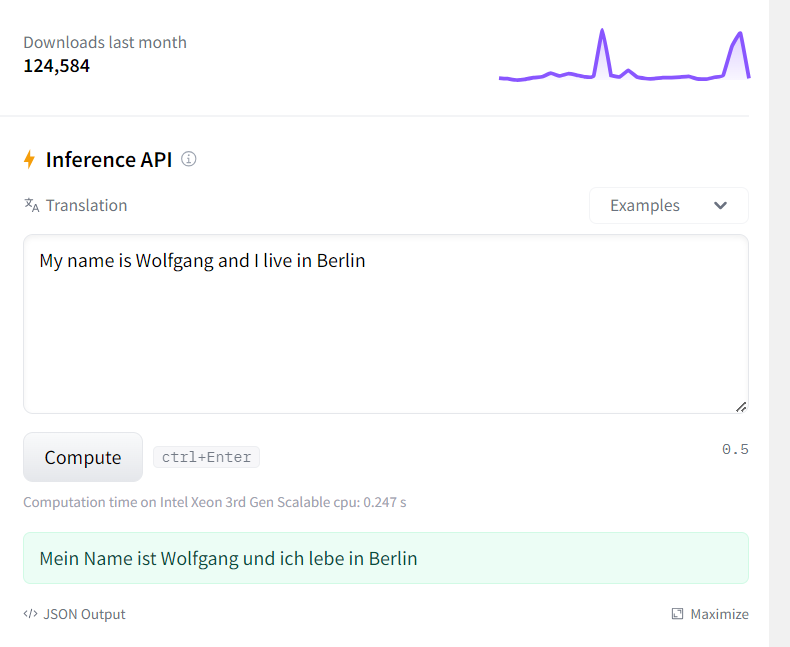


We will see how to easily load the dataset for this task using Datasets and how to fine-tune a model on it using the Trainer API

This notebook is built to run with any model checkpoint from the Model Hub as long as that model has a sequence-to-sequence version in the Transformers library. Here we picked the Helsinki-NLP/opus-mt-en-de checkpoint.
**[You may not download the model when you working in private cloud, we can download model from Files and versions tab.]**



In [ ]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-de"

### Loading the dataset

We will use the [datasets](https://github.com/huggingface/datasets/tree/master/datasets/wmt16) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric. We use the English/German part of the WMT dataset here

In [ ]:
from datasets import load_dataset, load_metric
raw_datasets = load_dataset("wmt16", "de-en")
metric = load_metric("sacrebleu")

<ipython-input-5-b496ea293c11>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


The dataset object itself is [datasetdict](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set:

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 4548885
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2169
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2999
    })
})

In [ ]:
print("Format of the dataset")
for i in range(10):
  print(raw_datasets["train"][i])
  print('\n')

Format of the dataset
{'translation': {'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}}


{'translation': {'de': 'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.', 'en': 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.'}}


{'translation': {'de': 'Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.', 'en': "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful."}}


To get a sense of how the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))
show_random_elements(raw_datasets["train"])

,translation
0,"{'de': 'Ecole du Tourisme et de l'Hôtellerie : de 1 à 3 ans pour exercer un métier dans le Tourisme et /ou l'hôtellerie.', 'en': 'Portail du tourisme au Maroc : actualité, dossiers, interviews, revue de Presse ... la 9è édition du Trophée ""Roses des Sables"" qui s'est déroulée en octobre dernier au Maroc ...'}"
1,"{'de': 'Im Schatten des Langkofels durchkehren wir die steinerne Stadt bis zum Rifugio Comici, eine einladende Berghütte für eine Pause.', 'en': 'In the shadow of the Sassolungo we ride across the City of Stones reaching the Rifugio Comici, an inviting hut for taking a rest.'}"
2,"{'de': 'Hier als erstes die Geschichte, wie sie real sein könnte mit der Untersuchung, mit Ultraschall Sonde anal und Fingerclip mit Pulsoxiometer.', 'en': 'I have to undress and lay down on the gyntable, got a fingerclip from the pulsoximeter and the ultrasound stick in my ass.'}"
3,"{'de': 'Insbesondere durch Bündelung von mehreren UMTS-Zugängen verschiedener Netzanbieter wird es damit erstmals möglich, Software as a Service auch mobil über UMTS-Netze zu betreiben.', 'en': 'Especially through bundling several UMTS/3G connections of different providers the reliable mobile operation of SaaS on UMTS/3G devices solutions is possible for the first time.'}"
4,"{'de': 'ie Grundwahrheiten der Scientology-Religion wirken sich auf jeden Aspekt des Lebens aus  die Gestaltung harmonischer Beziehungen, die Lösung von familiären Konflikten, effektive Kommunikation am Arbeitsplatz, wie man mit Stress fertig wird und vieles andere mehr. All das entdeckt man auf dem Weg zu völliger spiritueller Freiheit.', 'en': 'he fundamentals of the Scientology religion apply to every aspect of life  creating successful relationships, dealing with stress, communicating with others and resolving family problems and more, all on the road to true spiritual freedom.'}"


In [ ]:
metric

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

You can call its compute method with your predictions and labels, which need to be list of decoded strings (list of list for the labels):

In [ ]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = [["hello there"], ["general kenobi"]]
metric.compute(predictions=fake_preds, references=fake_labels)

{'score': 0.0,
 'counts': [4, 2, 0, 0],
 'totals': [4, 2, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

# Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

we get a tokenizer that corresponds to the model architecture we want to use,
we download the vocabulary used when pretraining this specific checkpoint.
That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

If you downloaded the model manually, you can provide model present directory instead of model_checkpoint

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


You can directly call this tokenizer on one sentence or a pair of sentences:

In [ ]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[16816, 2, 60, 128, 12512, 68, 0], [140, 19, 811, 12512, 3, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

To prepare the targets for our model, we need to tokenize them inside the as_target_tokenizer context manager. This will make sure the tokenizer uses the special tokens corresponding to the targets:

In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[8152, 166, 2, 60, 32, 18, 7795, 46, 2066, 68, 0], [140, 19, 39, 5748, 45, 7795, 46, 2066, 3, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


We can then write the function that will preprocess our samples. We just feed them to the tokenizer with the argument truncation=True. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

In [ ]:
prefix = ""
max_input_length = 128
max_target_length = 128
source_lang = "en"
target_lang = "de"
def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
preprocess_function(raw_datasets['train'][:2])

{'input_ids': [[465, 32932, 7, 4, 6274, 0], [38, 18950, 38309, 4, 6274, 7, 4, 151, 626, 3059, 29423, 8575, 32, 5682, 507, 1088, 17129, 8, 38, 206, 209, 1430, 696, 12, 2455, 41, 14, 3360, 168, 332, 5, 4, 2190, 35, 41, 13489, 14, 8375, 39030, 712, 3, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[35999, 9, 4371, 25478, 0], [105, 34827, 11, 121, 5736, 2, 57, 4675, 1128, 25548, 18, 4371, 25478, 40, 320, 1396, 28, 427, 1726, 9692, 2, 23987, 373, 17617, 667, 8448, 123, 1926, 5806, 10, 6497, 2, 194, 42, 4681, 7677, 1451, 3, 0]]}

To apply this function on all the pairs of sentences in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the AutoModelForSeq2SeqLM class. Like with the tokenizer, the from_pretrained method will download and cache the model for us.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

To instantiate a Seq2SeqTrainer, we will need to define three more things. The most important is the [Seq2SeqTrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
accelerate.__version__

'0.25.0'

In [ ]:
import accelerate
import transformers

In [ ]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the batch_size defined at the top of the cell and customize the weight decay. Since the Seq2SeqTrainer will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the predict_with_generate option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

Model will save under **{model_name}-finetuned-{source_lang}-to-{target_lang}** directory

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our Seq2SeqTrainer is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [ ]:
import numpy as np
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

Then we just need to pass all of this along with our datasets to the Seq2SeqTrainer:

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the train method:

In [ ]:
trainer.train()

In [ ]:
import os
for dirname, _, filenames in os.walk('opus-mt-en-de-finetuned-en-to-de'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

opus-mt-en-de-finetuned-en-to-de/runs/Dec01_18-51-28_d61510393f5e/events.out.tfevents.1701456755.d61510393f5e.10307.0
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/training_args.bin
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/model.safetensors
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/config.json
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/source.spm
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/vocab.json
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/rng_state.pth
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/tokenizer_config.json
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/generation_config.json
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/optimizer.pt
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/special_tokens_map.json
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/scheduler.pt
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/target.spm
opus-mt-en-de-finetuned-en-to-de/checkpoint-13000/trainer_state.json
opus-mt-en-de-finetuned

Our fine tuned model already saved under *opus-mt-en-de-finetuned-en-to-de/checkpoint-14000*

Load the model and translate some text from english to german

In [ ]:
from transformers import OpusMTModel, OpusTokenizer
src_text = ['My name is Sarah and I live in London']

model_name = 'opus-mt-en-de-finetuned-en-to-de/checkpoint-14000'
tokenizer = OpusTokenizer.from_pretrained(model_name)
print(tokenizer.supported_language_codes)


[]


/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
model = OpusMTModel.from_pretrained(model_name)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

['Mein Name ist Sarah und ich lebe in London']

our fine tune model is doing very good and close to google translator

**input text** -> My name is Sarah and I live in London

**fine-tune model prediction** -> Mein Name ist Sarah und ich lebe in London

**google translator prediction** -> Mein Name ist Sarah und ich lebe in London

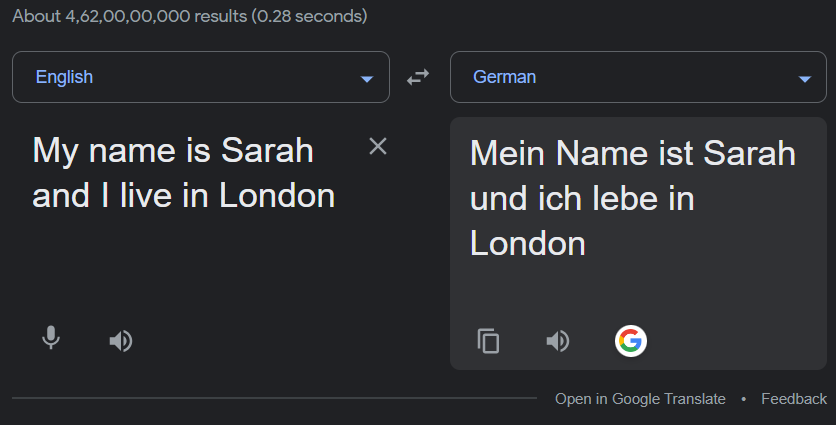

